In [1]:
##import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from textwrap import wrap
from PIL import Image
import os
import cv2
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
image_path = "C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/Images"

In [3]:
data = pd.read_csv("C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [5]:
#Converts a PIL Image instance to a Numpy array. 
#If you start from a PNG image, the values inside the image will lie between 0 and 255
#img_to_array however will cast to float. In your code example, the array is divided by 255, 
#so that's why you end up with floats between 0 and 1.
#This code is actually for reducing the range of values from 0-255 to 0-1
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)/255
    
    return img
#Reset the index, or a level of it. If the DataFrame has a MultiIndex, this method can remove one or more levels.
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], width = 20)))
        plt.axis("off")

#we wrap the title to a specified width (in this case, 20 characters). 
#We then join the wrapped lines using the newline character (\n) 
#and set the wrapped title as the plot title.

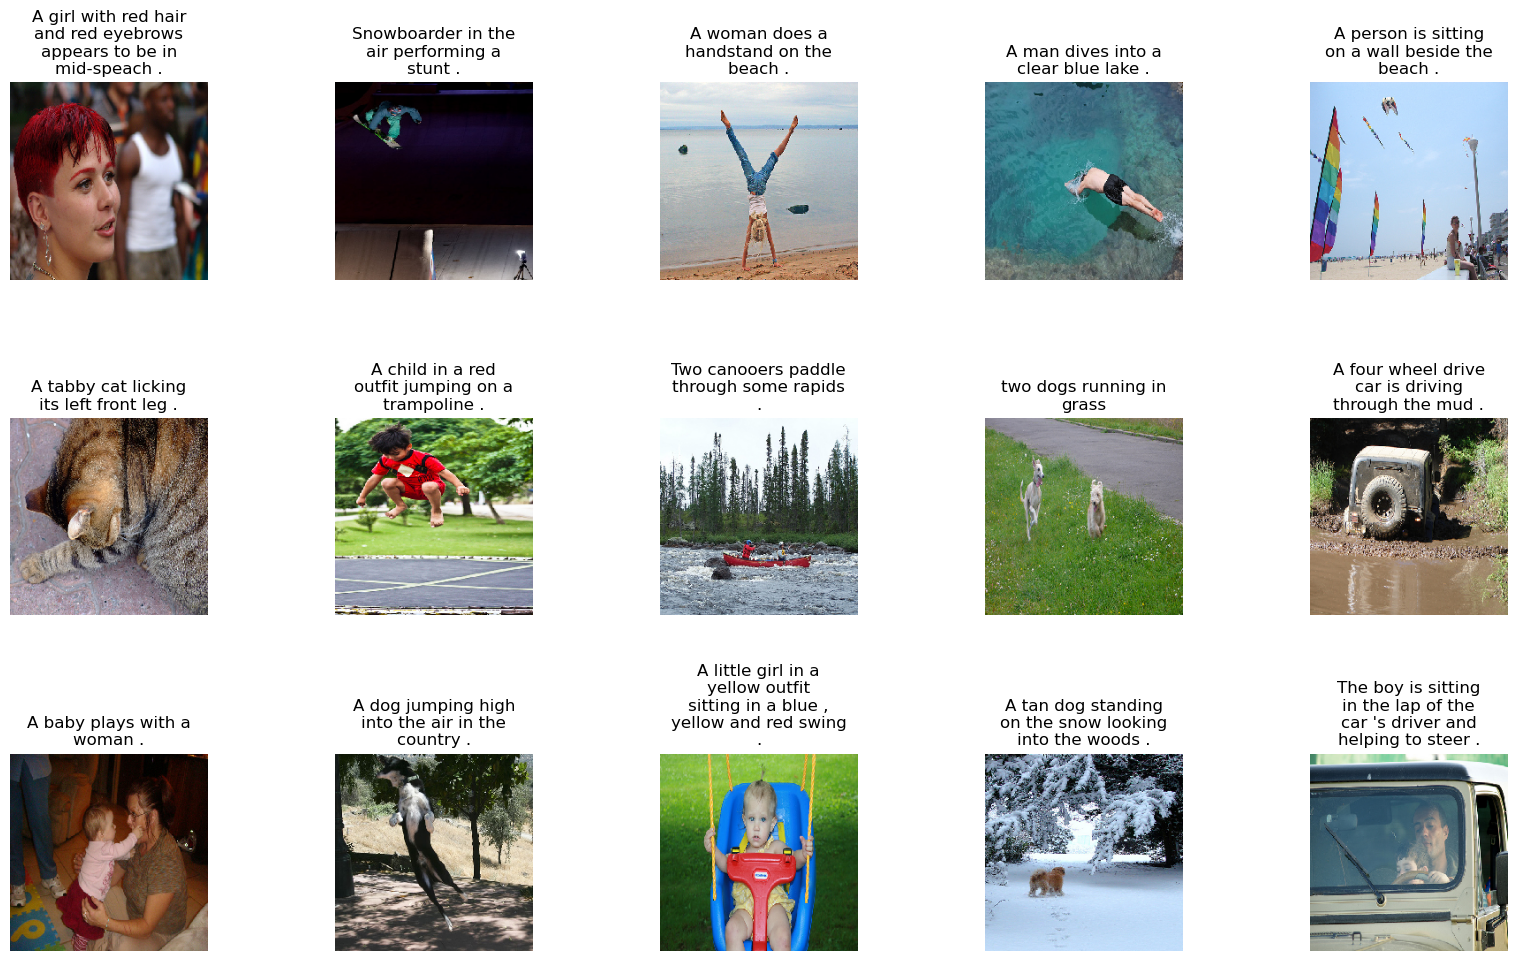

In [6]:
display_images(data.sample(15))

In [7]:
# Text preprocessing with stemming and lemmatization
##convert to lower case
## delete digits, special chars, etc ( remove non-alphabetical characters).
## delete additional spaces
## add start and end tags to the caption
def text_preprocessing(data):
    def preprocess_caption(caption):
        caption = caption.lower()
        caption = re.sub("[^a-z\s]", "", caption)
        caption = re.sub("\s+", " ", caption)
        words = caption.split()
        words = [word for word in words if len(word) > 1]
        words = [lemmatizer.lemmatize(word) for word in words]
        words = [stemmer.stem(word) for word in words]
        return " ".join(words)

    data['caption'] = data['caption'].apply(preprocess_caption)
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()


In [8]:
captions[:10]

['startseq child in pink dress is climb up set of stair in an entri way endseq',
 'startseq girl go into wooden build endseq',
 'startseq littl girl climb into wooden playhous endseq',
 'startseq littl girl climb the stair to her playhous endseq',
 'startseq littl girl in pink dress go into wooden cabin endseq',
 'startseq black dog and spot dog are fight endseq',
 'startseq black dog and tricolor dog play with each other on the road endseq',
 'startseq black dog and white dog with brown spot are stare at each other in the street endseq',
 'startseq two dog of differ breed look at each other on the road endseq',
 'startseq two dog on pavement move toward each other endseq']

In [9]:
#The words in a sentence are separated/tokenized and encoded in a one hot representation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1

In [10]:
vocab_size

6036

In [11]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in captions)
max_length

34

In [12]:
#These encodings are then passed to the embeddings layer to generate word embeddings
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 14, 201, 64, 194, 112, 2]

In [13]:
# Prepare image feature extraction model
def preprocess_image(image_file, target_size=224):
    img = Image.open(os.path.join(image_path, image_file))
    # Resize the image maintaining the aspect ratio
    img.thumbnail((target_size, target_size))
    # Create a new image with a white background and centers the resized image on the new background
    new_img = Image.new("RGB", (target_size, target_size), (255, 255, 255))
    new_img.paste(img, ((target_size - img.width) // 2, (target_size - img.height) // 2))
     # Convert the image to a NumPy array and normalize the image data to the range [0, 1]
    img_array = img_to_array(new_img) / 255.0
    
    return np.expand_dims(img_array, axis=0)
    ##If your images are already clear, there's no need to apply Gaussian blu
    #img_array_blur = cv2.GaussianBlur(img_array, (3, 3), 0)


# Function to display preprocessed images
def check_preprocessed_images(image_files, num_images=5, target_size=224):
    plt.figure(figsize=(15, 15))
    for i, image_file in enumerate(image_files[:num_images]):
        preprocessed_image = preprocess_image(image_file, target_size)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(preprocessed_image[0])
        plt.axis('off')
    plt.show()


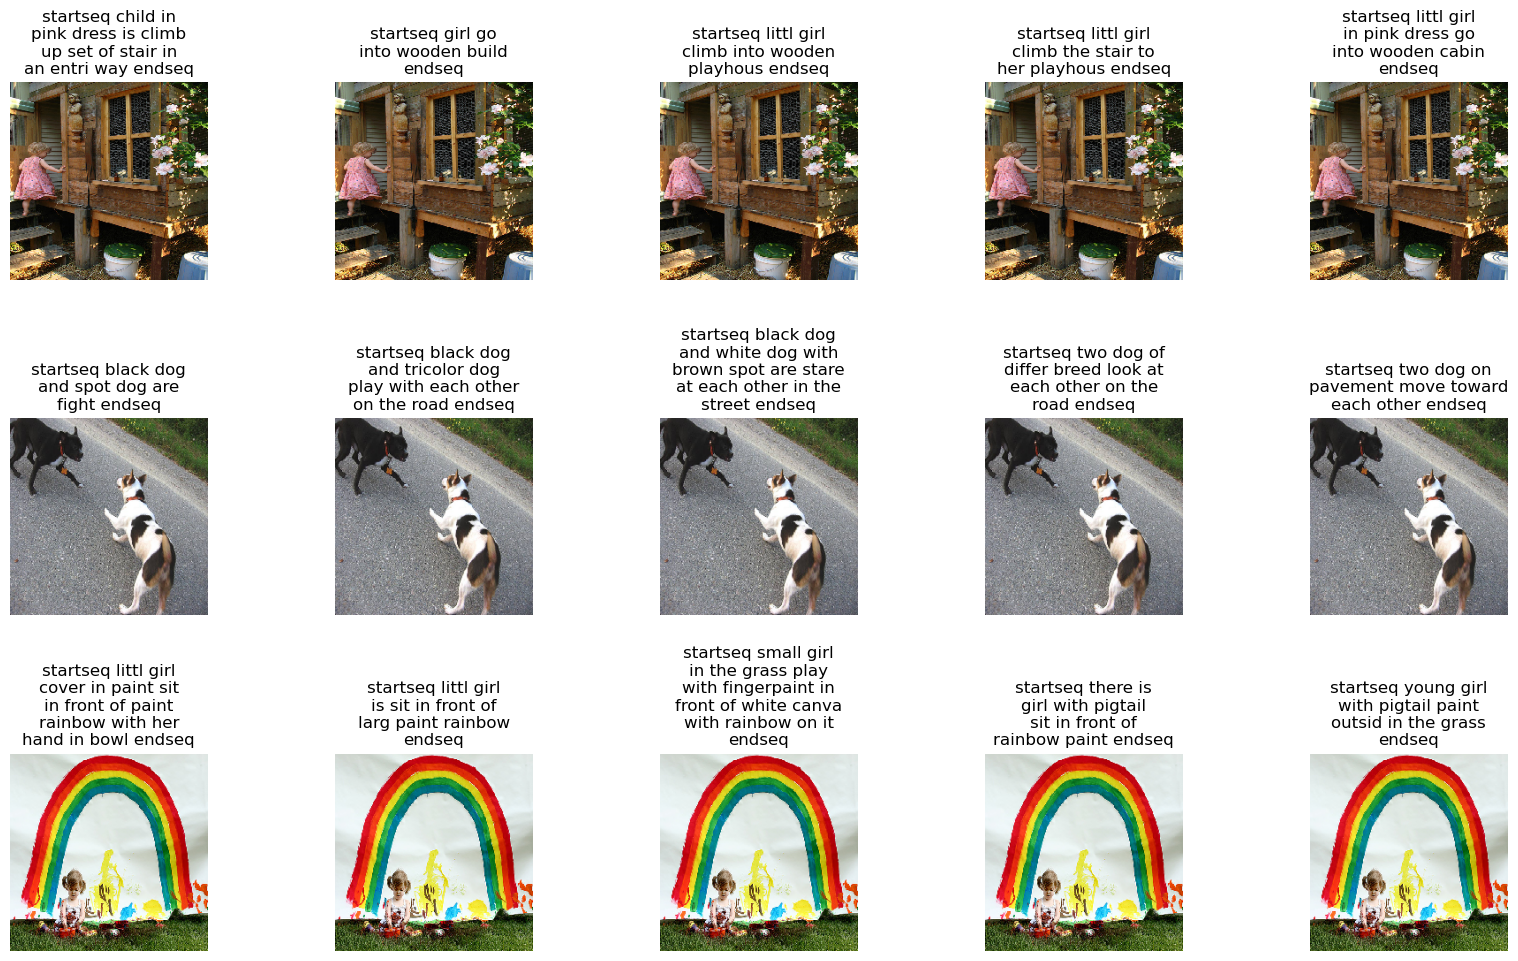

In [14]:
# Display some sample images with captions
display_images(data)

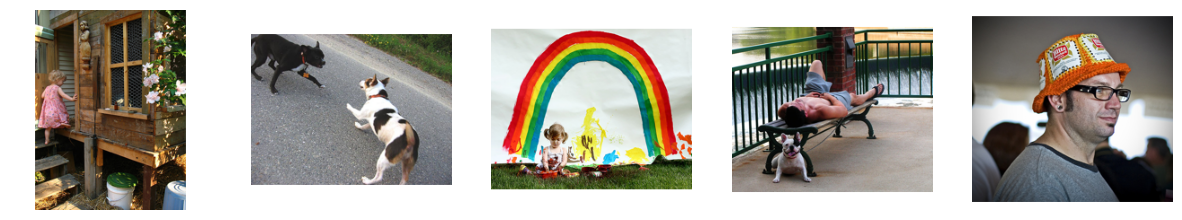

In [15]:
# Sample images to check preprocessing
sample_images = data['image'].unique().tolist()[:10]  # Take first 10 unique image filenames
check_preprocessed_images(sample_images, num_images=5)

In [24]:
# Feature extraction
model = DenseNet201()
f_extract = Model(inputs=model.input, outputs=model.layers[-2].output)

# Set image size and initialize features dictionary
img_size = 224
features = {}

# Loop through images and extract features
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = f_extract.predict(img, verbose=0)
    features[image] = feature

# Save the extracted features for later use
np.save("image_features.npy", features)
# this code loads a pre-trained DenseNet201 model, modifies it to extract features,
# and then iterates through a set of images to extract and store these features in a dictionary

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [41:17<00:00,  3.27it/s]


In [16]:

# Split dataset into train, test, and validation sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.6666, random_state=42)


In [17]:
# Map captions to images
train_descriptions = {k: list(train_data[train_data['image'] == k]['caption']) for k in train_data['image'].unique().tolist()}
test_descriptions = {k: list(test_data[test_data['image'] == k]['caption']) for k in test_data['image'].unique().tolist()}
val_descriptions = {k: list(val_data[val_data['image'] == k]['caption']) for k in val_data['image'].unique().tolist()}

In [36]:
class DataGenerator(Sequence):
    def __init__(self, descriptions, photos, tokenizer, max_length, vocab_size, batch_size=32):
        self.descriptions = descriptions
        self.photos = photos
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.keys = list(descriptions.keys())

    def __len__(self):
        return int(np.ceil(len(self.keys) / self.batch_size))

    def __getitem__(self, index):
        keys = self.keys[index * self.batch_size:(index + 1) * self.batch_size]
        X1, X2, y = self.__data_generation(keys)
        return (X1, X2), y

    def __data_generation(self, keys):
        X1 = np.zeros((self.batch_size, 1920))  # Assuming photo features are of shape (1920,)
        X2 = np.zeros((self.batch_size, self.max_length))  # Assuming max_length for padded sequences
        y = np.zeros((self.batch_size, self.vocab_size))  # Assuming vocab_size for one-hot encoded labels

        for i, key in enumerate(keys):
            photo = self.photos[key]  # Assuming self.photos is a dictionary
            desc_list = self.descriptions[key]

            X1[i] = photo[0]  # Assign photo features to X1 batch
            sequence = self.tokenizer.texts_to_sequences([desc_list])[0]
            padded_sequence = pad_sequences([sequence], maxlen=self.max_length)[0]
            X2[i] = padded_sequence  # Assign padded sequence to X2 batch
            y[i] = to_categorical([sequence[-1]], num_classes=self.vocab_size)[0]  # Assign one-hot label to y batch

        return (X1, X2), y

In [37]:
train_generator = DataGenerator(train_descriptions, features, tokenizer, max_length, vocab_size, batch_size=32)
val_generator = DataGenerator(val_descriptions, features, tokenizer, max_length, vocab_size, batch_size=32)
test_generator = DataGenerator(test_descriptions, features, tokenizer, max_length, vocab_size, batch_size=32)

In [38]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        ((tf.TensorSpec(shape=(None, 1920), dtype=tf.float32), 
          tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
         tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32))
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        (tf.TensorSpec(shape=(None, 1920), dtype=tf.float32),
         tf.TensorSpec(shape=(None, max_length), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        ((tf.TensorSpec(shape=(None, 1920), dtype=tf.float32), 
          tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
         tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32))
    )
)

In [39]:
# Define the image captioning model
def define_model(vocab_size, max_length):
    # Feature extractor model
    inputs1 = Input(shape=(1920,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # Decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Tie it together [image, seq] -> word
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model


In [40]:
# Define the model
model = define_model(vocab_size, max_length)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 34)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 34, 256)           │       1,545,216 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 1920)              │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 34, 256)           │               0 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_2 (NotEqual)        │ (None, 34)                │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 256)               │         491,776 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 256)               │         525,312 │ dropout_5[0][0],           │
│                               │                           │                 │ not_equal_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 256)               │               0 │ dense_6[0][0],             │
│                               │                           │                 │ lstm_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 256)               │          65,792 │ add_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 6036)              │       1,551,252 │ dense_7[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,179,348 (15.94 MB)

 Trainable params: 4,179,348 (15.94 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Define checkpoint callback
checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
# Fit the model
history = model.fit(train_dataset, 
                    epochs=2,
                    verbose=1,
                    validation_data=val_dataset, 
                    callbacks=[checkpoint, early_stop])